In [31]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [32]:
PATH = '/Users/microwave/AIO_2024/Module_5/Week2/creditcard.csv'

df = pd.read_csv(PATH)
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [33]:
df_arr = df.to_numpy()
X,y = df_arr[:,:-1].astype(np.float64), df_arr[:,-1].astype(np.uint8)

In [34]:
intercept = np.ones((X.shape[0],1))

X_b = np.concatenate((intercept,X),axis=1)

In [35]:
n_classes = np.unique(y, axis = 0).shape[0]
n_samples = y.shape[0]

y_encoded = np.array([np.zeros(n_classes) for _ in range(n_samples)])
y_encoded[np.arange(n_samples), y] = 1

y_encoded[0:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [36]:
val_size = 0.2
test_size = 0.125
shuffle = True
seed = 2

X_train, X_val, y_train, y_val = train_test_split(X_b, y_encoded, test_size= val_size, random_state=seed, shuffle=shuffle)
X_train,X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=test_size, random_state=seed, shuffle=shuffle)

In [37]:
normalier = StandardScaler()
X_train[:,1:] = normalier.fit_transform(X_train[:,1:])
X_val[:,1:] = normalier.transform(X_val[:,1:])
X_test[:,1:] = normalier.transform(X_test[:,1:])

In [38]:
def softmax(z):
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis=1)[:,None]

def predict(X,theta):
    z = np.dot(X,theta)
    y_hat = softmax(z)
    return y_hat

def compute_loss(y_hat,y):
    n = y.size
    return (-1/n) * np.sum(y * np.log(y_hat))

def compute_gradient(X,y,y_hat):
    n = y.size 
    return np.dot(X.T, (y_hat - y)) / n

def update_theta(theta,gradient,lr):
    return theta - lr * gradient

def compute_accuracy(X,y,theta):
    y_hat = predict(X,theta).round()
    acc = (np.argmax(y_hat, axis=1) == np.argmax(y, axis=1)).mean()
    return acc

    

In [39]:
LR = 0.01
EPOCHS = 30
BATCH_SIZE = 1024
n_features = X_train.shape[1]

np.random.seed(seed)
theta = np.random.uniform(size = (n_features, n_classes))

In [40]:
def trainer(epoch, lr, batch_size, X_train, y_train, X_val, y_val, theta):
    train_accs = []
    val_accs = []
    train_losses = []
    val_losses = []

    for epoch in range(EPOCHS):
        train_batch_losses = []
        train_batch_accs = []
        val_batch_losses = []
        val_batch_accs = []

        for i in range(0, X_train.shape[0], BATCH_SIZE):
            X_i = X_train[i:i+BATCH_SIZE]
            y_i = y_train[i:i+BATCH_SIZE]

            y_hat = predict(X_i,theta)

            train_loss = compute_loss(y_hat,y_i)

            gradient = compute_gradient(X_i,y_i,y_hat)

            theta = update_theta(theta,gradient,LR)

            train_batch_losses.append(train_loss)

            train_acc = compute_accuracy(X_train,y_train,theta)
            train_batch_accs.append(train_acc)

            y_val_hat = predict(X_val,theta)
            val_losss = compute_loss(y_val_hat,y_val)
            val_batch_losses.append(val_losss)

            val_acc = compute_accuracy(X_val,y_val,theta)
            val_batch_accs.append(val_acc)

        train_batch_losses = np.mean(train_batch_losses)
        train_batch_accs = np.mean(train_batch_accs)
        val_batch_losses = np.mean(val_batch_losses)
        val_batch_accs = np.mean(val_batch_accs)

        train_accs.append(train_batch_accs)
        val_accs.append(val_batch_accs)
        train_losses.append(train_batch_losses)
        val_losses.append(val_batch_losses)

        print(f'Epoch {epoch+1} \\t| Loss: {train_batch_losses:.3f} \\t| Accuracy: {train_batch_accs:.3f} \\t| Val Loss: {val_batch_losses:.3f} \\t| Val Accuracy: {val_batch_accs:.3f}')

    return train_accs, val_accs, train_losses, val_losses

In [41]:
train_accs, val_accs, train_losses, val_losses = trainer(EPOCHS, LR, BATCH_SIZE, X_train, y_train, X_val, y_val, theta)

Epoch 1 \t| Loss: 0.300 \t| Accuracy: 0.741 \t| Val Loss: 0.297 \t| Val Accuracy: 0.743
Epoch 2 \t| Loss: 0.176 \t| Accuracy: 0.909 \t| Val Loss: 0.174 \t| Val Accuracy: 0.909
Epoch 3 \t| Loss: 0.115 \t| Accuracy: 0.971 \t| Val Loss: 0.113 \t| Val Accuracy: 0.972
Epoch 4 \t| Loss: 0.081 \t| Accuracy: 0.987 \t| Val Loss: 0.080 \t| Val Accuracy: 0.987
Epoch 5 \t| Loss: 0.062 \t| Accuracy: 0.993 \t| Val Loss: 0.061 \t| Val Accuracy: 0.993
Epoch 6 \t| Loss: 0.049 \t| Accuracy: 0.996 \t| Val Loss: 0.049 \t| Val Accuracy: 0.996
Epoch 7 \t| Loss: 0.041 \t| Accuracy: 0.997 \t| Val Loss: 0.041 \t| Val Accuracy: 0.998
Epoch 8 \t| Loss: 0.035 \t| Accuracy: 0.998 \t| Val Loss: 0.035 \t| Val Accuracy: 0.998
Epoch 9 \t| Loss: 0.031 \t| Accuracy: 0.999 \t| Val Loss: 0.031 \t| Val Accuracy: 0.999
Epoch 10 \t| Loss: 0.028 \t| Accuracy: 0.999 \t| Val Loss: 0.027 \t| Val Accuracy: 0.999
Epoch 11 \t| Loss: 0.025 \t| Accuracy: 0.999 \t| Val Loss: 0.025 \t| Val Accuracy: 0.999
Epoch 12 \t| Loss: 0.023 \t| A

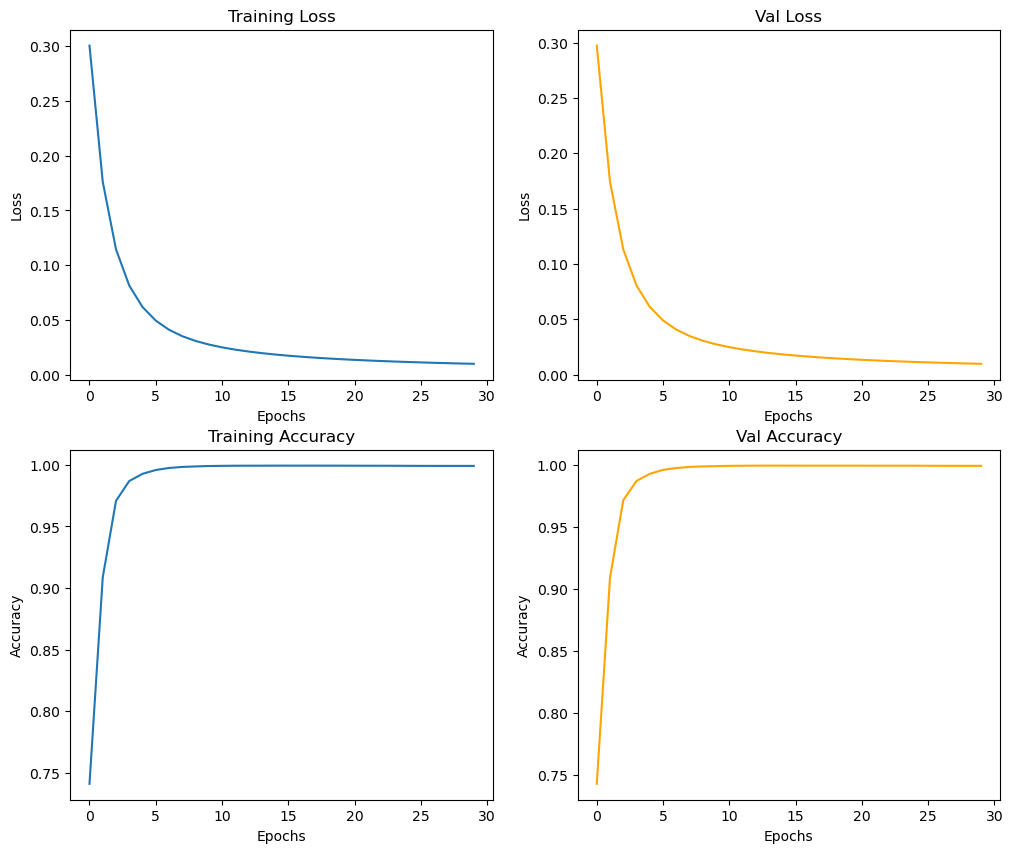

In [42]:
fig, ax = plt.subplots(2,2, figsize = (12,10))

ax[0,0].plot(train_losses)
ax[0,0].set(xlabel = 'Epochs', ylabel = 'Loss')
ax[0,0].set_title('Training Loss')

ax[0,1].plot(val_losses,'orange')
ax[0,1].set(xlabel = 'Epochs', ylabel = 'Loss')
ax[0,1].set_title('Val Loss')

ax[1,0].plot(train_accs)
ax[1,0].set(xlabel = 'Epochs', ylabel = 'Accuracy')
ax[1,0].set_title('Training Accuracy')

ax[1,1].plot(val_accs,'orange')
ax[1,1].set(xlabel = 'Epochs', ylabel = 'Accuracy')
ax[1,1].set_title('Val Accuracy')

plt.show()

In [43]:
val_set_acc = compute_accuracy(X_val,y_val,theta)
test_set_acc = compute_accuracy(X_test,y_test,theta)
print(f'Validation Set Accuracy: {val_set_acc:.3f} \nTest Set Accuracy: {test_set_acc:.3f}')

Validation Set Accuracy: 0.627 
Test Set Accuracy: 0.621


# Sentiment analysis

In [44]:
import nltk

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/microwave/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
PATH = '/Users/microwave/AIO_2024/Module_5/Week2/Twitter_Data.csv'

df = pd.read_csv(PATH)
df.head(5)


,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [47]:
df = df.dropna()

In [48]:
def text_normalize(text):
# Retweet old acronym "RT" removal
    text = text.lower

    text = re.sub(r'^RT [\s]+ ', '', text )

    # Hyperlinks removal
    text = re.sub(r'https ?:\/\/.*[\ r\n]* ', '', text )

    # Punctuation removal
    text = re.sub(r'[^\ w\s]', '', text )

    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    text = ''.jon(words)

    stemmer = SnowballStemmer('english')
    words = text.split()
    words = [stemmer.stem(word) for word in words]
    text = ''.jon(words)

    return text

In [49]:
vectorizer = TfidfVectorizer(max_features=2000)
X = vectorizer.fit_transform(df['clean_text']).toarray()

In [50]:
intercept = np.ones((X.shape[0],1))
X_b = np.concatenate((intercept, X),axis =1)

In [51]:
n_classes = df['category'].nunique()
n_samples = df['category'].size

y = df['category'].to_numpy() + 1
y = y.astype(np.uint8)
y_encoded = np.array([np.zeros(n_classes) for _ in range(n_samples)])



In [52]:
val_size = 0.2
test_size = 0.125
shuffle = True
seed = 2

X_train, X_val, y_train, y_val = train_test_split(X_b, y_encoded, test_size= val_size, random_state=seed, shuffle=shuffle)
X_train,X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=test_size, random_state=seed, shuffle=shuffle)

In [53]:
def softmax(z):
    exp_z = np.exp(z)
    return exp_z / exp_z.sum(axis =1)[:, None]

def predict(X,theta):
    z = np.dot(X,theta)
    y_hat = softmax(z)
    return y_hat

def compute_loss(y_hat,y):
    n = y.size
    return (-1/n) * np.sum(y * np.log(y_hat))

def compute_gradient(X,y,y_hat):
    n = y.size 
    return np.dot(X.T, (y_hat - y)) / n

def update_theta(theta,gradient,lr):
    return theta - lr * gradient

def compute_accuracy(X,y,theta):
    y_hat = predict(X,theta)
    acc = (np.argmax(y_hat, axis=1) == np.argmax(y, axis=1)).mean()
    return acc

    

In [54]:
LR = 0.01
EPOCHS = 200
BATCH_SIZE = X_train.shape[0]
n_features = X_train.shape[1]

theta = np.random.uniform(size = (n_features, n_classes))

In [55]:
def trainer(epoch, lr, batch_size, X_train, y_train, X_val, y_val, theta):
    train_accs = []
    val_accs = []
    train_losses = []
    val_losses = []

    for epoch in range(EPOCHS):
        train_batch_losses = []
        train_batch_accs = []
        val_batch_losses = []
        val_batch_accs = []

        for i in range(0, X_train.shape[0], BATCH_SIZE):
            X_i = X_train[i:i+BATCH_SIZE]
            y_i = y_train[i:i+BATCH_SIZE]

            y_hat = predict(X_i,theta)

            train_loss = compute_loss(y_hat,y_i)

            gradient = compute_gradient(X_i,y_i,y_hat)

            theta = update_theta(theta,gradient,LR)

            train_batch_losses.append(train_loss)

            train_acc = compute_accuracy(X_train,y_train,theta)
            train_batch_accs.append(train_acc)

            y_val_hat = predict(X_val,theta)
            val_losss = compute_loss(y_val_hat,y_val)
            val_batch_losses.append(val_losss)

            val_acc = compute_accuracy(X_val,y_val,theta)
            val_batch_accs.append(val_acc)

        train_batch_losses = np.mean(train_batch_losses)
        train_batch_accs = np.mean(train_batch_accs)
        val_batch_losses = np.mean(val_batch_losses)
        val_batch_accs = np.mean(val_batch_accs)

        train_accs.append(train_batch_accs)
        val_accs.append(val_batch_accs)
        train_losses.append(train_batch_losses)
        val_losses.append(val_batch_losses)

        print(f'Epoch {epoch+1} \\t| Loss: {train_batch_losses} \\t| Accuracy: {train_batch_accs:.3f} \\t| Val Loss: {val_batch_losses} \\t| Val Accuracy: {val_batch_accs:.3f}')

    return train_accs, val_accs, train_losses, val_losses

In [56]:
train_accs, val_accs, train_losses, val_losses = trainer(EPOCHS, LR, BATCH_SIZE, X_train, y_train, X_val, y_val, theta)

Epoch 1 \t| Loss: 0.0 \t| Accuracy: 0.799 \t| Val Loss: 0.0 \t| Val Accuracy: 0.799
Epoch 2 \t| Loss: 0.0 \t| Accuracy: 0.799 \t| Val Loss: 0.0 \t| Val Accuracy: 0.798
Epoch 3 \t| Loss: 0.0 \t| Accuracy: 0.798 \t| Val Loss: 0.0 \t| Val Accuracy: 0.798
Epoch 4 \t| Loss: 0.0 \t| Accuracy: 0.798 \t| Val Loss: 0.0 \t| Val Accuracy: 0.797
Epoch 5 \t| Loss: 0.0 \t| Accuracy: 0.797 \t| Val Loss: 0.0 \t| Val Accuracy: 0.797
Epoch 6 \t| Loss: 0.0 \t| Accuracy: 0.797 \t| Val Loss: 0.0 \t| Val Accuracy: 0.796
Epoch 7 \t| Loss: 0.0 \t| Accuracy: 0.796 \t| Val Loss: 0.0 \t| Val Accuracy: 0.796
Epoch 8 \t| Loss: 0.0 \t| Accuracy: 0.796 \t| Val Loss: 0.0 \t| Val Accuracy: 0.796
Epoch 9 \t| Loss: 0.0 \t| Accuracy: 0.796 \t| Val Loss: 0.0 \t| Val Accuracy: 0.795
Epoch 10 \t| Loss: 0.0 \t| Accuracy: 0.795 \t| Val Loss: 0.0 \t| Val Accuracy: 0.795
Epoch 11 \t| Loss: 0.0 \t| Accuracy: 0.795 \t| Val Loss: 0.0 \t| Val Accuracy: 0.794
Epoch 12 \t| Loss: 0.0 \t| Accuracy: 0.795 \t| Val Loss: 0.0 \t| Val Accur

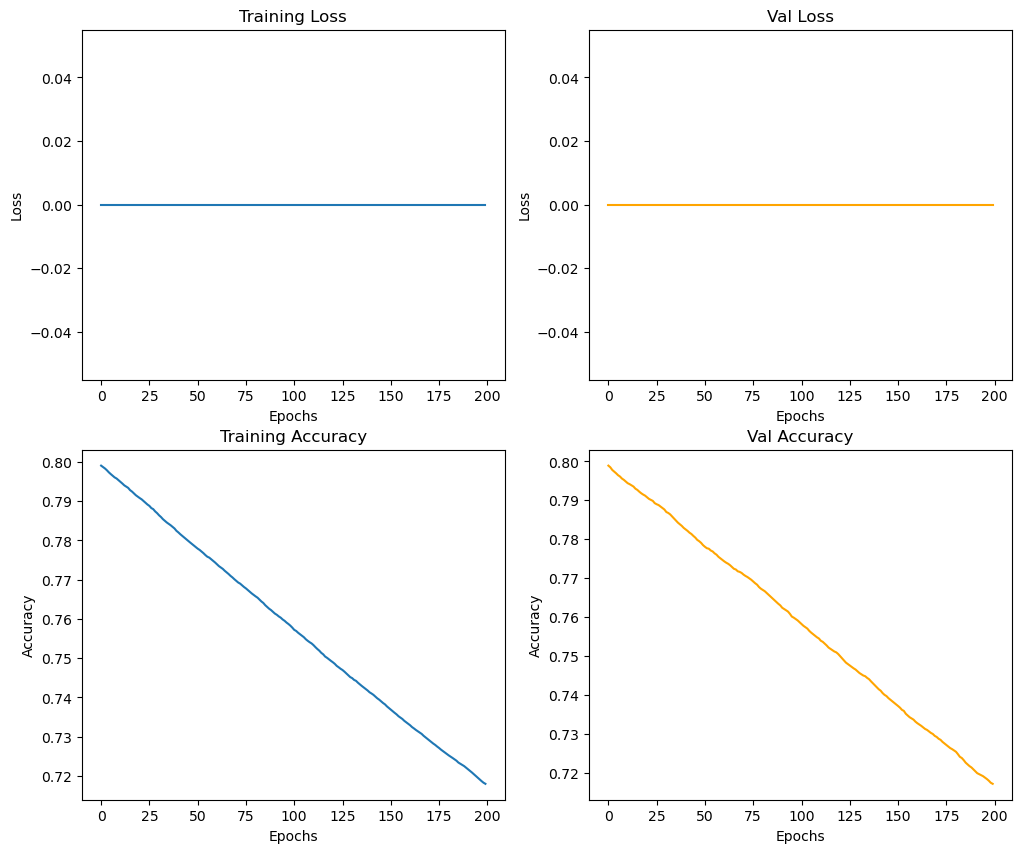

In [57]:
fig, ax = plt.subplots(2,2, figsize = (12,10))

ax[0,0].plot(train_losses)
ax[0,0].set(xlabel = 'Epochs', ylabel = 'Loss')
ax[0,0].set_title('Training Loss')

ax[0,1].plot(val_losses,'orange')
ax[0,1].set(xlabel = 'Epochs', ylabel = 'Loss')
ax[0,1].set_title('Val Loss')

ax[1,0].plot(train_accs)
ax[1,0].set(xlabel = 'Epochs', ylabel = 'Accuracy')
ax[1,0].set_title('Training Accuracy')

ax[1,1].plot(val_accs,'orange')
ax[1,1].set(xlabel = 'Epochs', ylabel = 'Accuracy')
ax[1,1].set_title('Val Accuracy')

plt.show()